<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/sun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solar Astronomy - Analysis of Sun**

In [5]:
!pip install sunpy reproject mpl_animators -q

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from scipy import ndimage

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.mpl_normalize import ImageNormalize

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.map.maputils import all_coordinates_from_map

import warnings
warnings.filterwarnings('ignore')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

AIA20110607_063302_0171_lowres.fits:   0%|          | 0.00/973k [00:00<?, ?B/s]

*The Atmospheric Imaging Assembly is a set of four telescopes that employ normal-incidence, multi-layer coated optics to provide narrow-band imaging of the Sun. It provides high resolution full-disk images of the corona and transition region up to 0.5 solar radii above the solar limb with 1.5 arcsecond angular resolution and 12-second temporal resolution. It observes the Sun in the following seven extreme ultraviolet bandpasses: 94 A (Fe XVIII), 131 A (Fe VIII, XXI), 171 A (Fe IX), 193 A (Fe XII, XXIV), 211 A (Fe XIV), 304 A (He II), 335 A (Fe XVI). One telescope observes in the visible 1600 A (C IV) and the nearby continuum (1700 A).*

*Observer location: The standard AIA FITS header provides the spacecraft location in multiple coordinate systems, including Heliocentric Aries Ecliptic (HAE) and Heliographic Stonyhurst (HGS). SunPy uses the provided HAE coordinates due to accuracy concerns with the provided HGS coordinates, but other software packages may make different choices.*

In [7]:
# Start with sample data
aia = sunpy.map.Map(AIA_171_IMAGE)

*Find and mask the brightest pixel*

In [8]:
# Find maximum in AIA image data then transform that pixel coordinate to a map coordinate
pixel_pos = np.argwhere(aia.data == aia.data.max()) * u.pixel
hpc_max = aia.wcs.pixel_to_world(pixel_pos[:, 1], pixel_pos[:, 0])

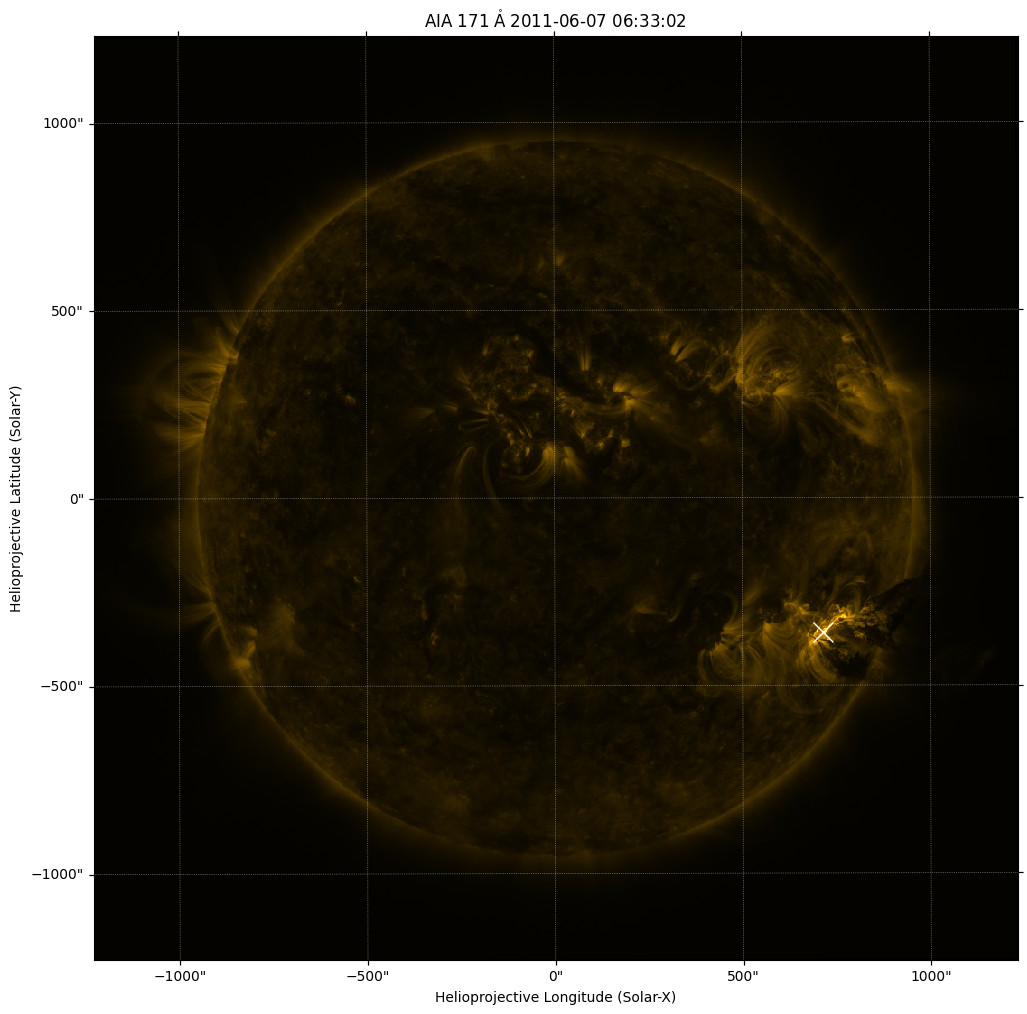

In [12]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(projection=aia)

aia.plot(axes=ax)
ax.plot_coord(hpc_max, color='white', marker='x', markersize=15)

plt.show()

<Figure size 1000x800 with 0 Axes>

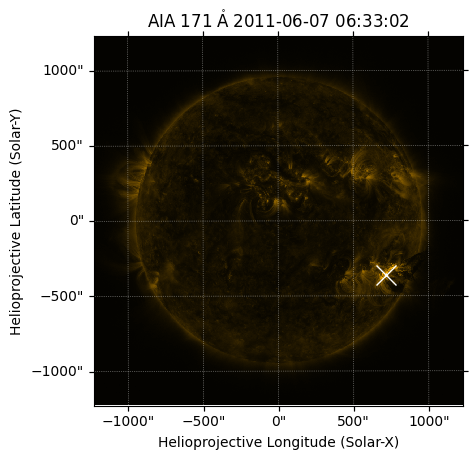

In [ ]:
plt.figure(figsize=(10, 8))
fig = plt.figure()
ax = fig.add_subplot(projection=aia)
aia.plot(axes=ax)
ax.plot_coord(hpc_max, color='white', marker='x', markersize=15)
plt.show()

A utility function gives us access to the helioprojective coordinate of each pixels. We create a new array which contains the normalized radial position for each pixel adjusted for the position of the brightest pixel (using hpc_max) and then create a new map.

In [ ]:
hpc_coords = all_coordinates_from_map(aia)
r_mask = np.sqrt((hpc_coords.Tx - hpc_max.Tx) ** 2 +
                 (hpc_coords.Ty - hpc_max.Ty) ** 2) / aia.rsun_obs
mask = ma.masked_less_equal(r_mask, 0.1)
scaled_map = sunpy.map.Map(aia.data, aia.meta, mask=mask.mask)

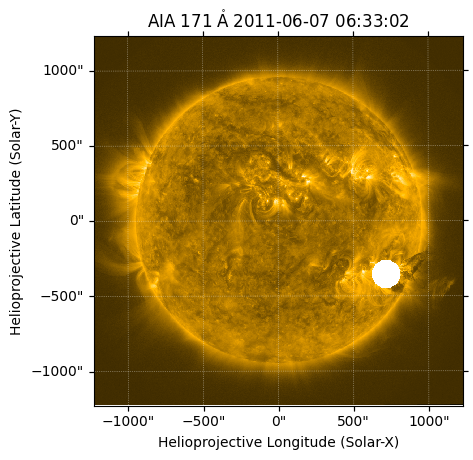

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=scaled_map)
scaled_map.plot(axes=ax)
plt.show()

*Edge Enhancing Coronal Loops*

In [ ]:
# sample data and crop it down to a region featuring coronal loops
aia = sunpy.map.Map(AIA_171_IMAGE)
bottom_left = SkyCoord(750 * u.arcsec, -200 * u.arcsec, frame=aia.coordinate_frame)
top_right = SkyCoord(1500 * u.arcsec, 550 * u.arcsec, frame=aia.coordinate_frame)
aia_smap = aia.submap(bottom_left, top_right=top_right)

In [ ]:
# apply an edge enhance filter to the data in both x and y directions and combine the two images together
sx = ndimage.sobel(aia_smap.data, axis=0, mode='constant')
sy = ndimage.sobel(aia_smap.data, axis=1, mode='constant')
edge_enhanced_im = np.hypot(sx, sy)

In [ ]:
# create a new map with the edge enhanced data
edge_map = sunpy.map.Map(edge_enhanced_im, aia_smap.meta)

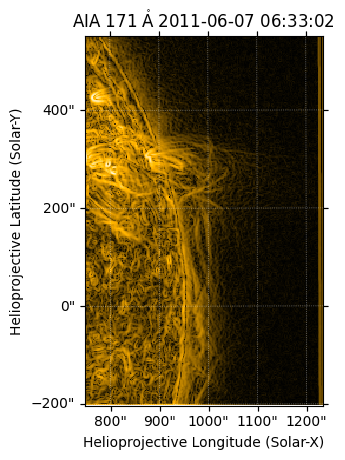

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=edge_map)
edge_map.plot(axes=ax)
plt.show()

*Enhancing off-disk emission (enhance emission above the limb)*

In [ ]:
# Sample data
aia = sunpy.map.Map(AIA_171_IMAGE)

In [ ]:
# A utility function gives access to helioprojective coordinate of each pixels
# Use that to create a new array which contains normalized radial position for each pixel
hpc_coords = all_coordinates_from_map(aia)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / aia.rsun_obs

In [ ]:
# Check how emission above limb depends on distance
rsun_step_size = 0.01
rsun_array = np.arange(1, r.max(), rsun_step_size)
y = np.array([aia.data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
              for this_r in rsun_array])

In [ ]:
# perform the fit in linear-log space
params = np.polyfit(rsun_array[rsun_array < 1.5],
                    np.log(y[rsun_array < 1.5]), 1)

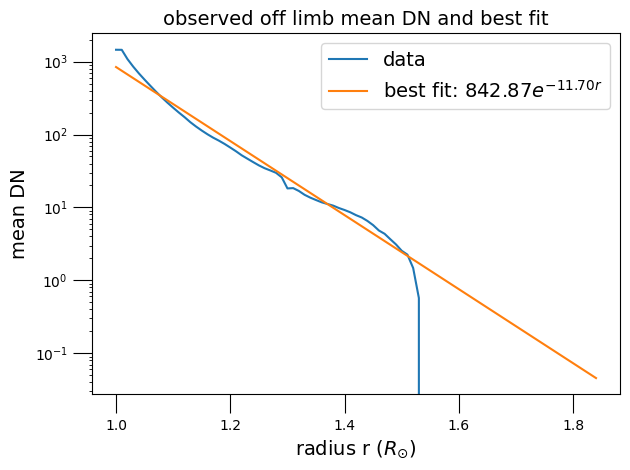

In [ ]:
fontsize = 14
fig, ax = plt.subplots()

ax.plot(rsun_array, y, label='data')
best_fit = np.exp(np.poly1d(params)(rsun_array))
label = fr'best fit: {best_fit[0]:.2f}$e^{{{params[0]:.2f}r}}$'
ax.plot(rsun_array, best_fit, label=label)
ax.set_yscale('log')
ax.set_ylabel(r'mean DN', fontsize=fontsize)
ax.set_xlabel(r'radius r ($R_{\odot}$)', fontsize=fontsize)
ax.tick_params(axis='both', size=fontsize)
ax.set_title(r'observed off limb mean DN and best fit', fontsize=fontsize)
ax.legend(fontsize=fontsize)
fig.tight_layout()

plt.show()

In [ ]:
# Create our normalization array. At solar radius and below, normalization is 1,
# while off-disk the normalization changes according to the fitted function above
scale_factor = np.exp((r-1)*-params[0])
scale_factor[r < 1] = 1

In [ ]:
# Create a new map with the normalized off-disk emission.
# Set normalization of the new map to be same as original map to compare both
scaled_map = sunpy.map.Map(aia.data * scale_factor, aia.meta)
scaled_map.plot_settings['norm'] = ImageNormalize(stretch=aia.plot_settings['norm'].stretch)

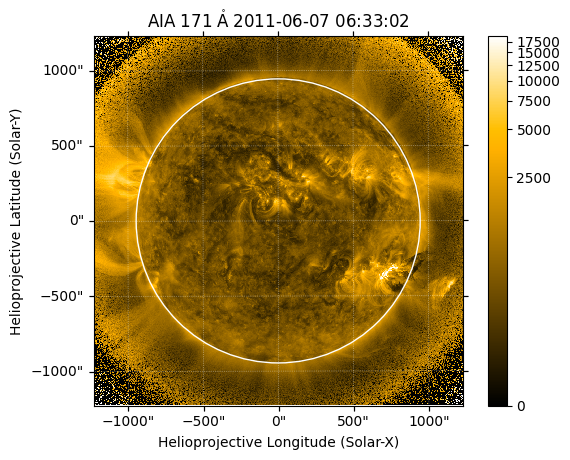

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=scaled_map)
im = scaled_map.plot(axes=ax, clip_interval=(5, 99.9)*u.percent)
scaled_map.draw_limb(axes=ax)
fig.colorbar(im)
plt.show()

***Solar Flares***

A major X7.1 solar flare (R3 radio blackout) peaked on 1 October at 22:20 UTC. The eruption took place around complex Beta-Gamma-Delta sunspot [News](https://www.spaceweatherlive.com/en/news.html). Also: [top-50-sonneneruptionen](https://www.spaceweatherlive.com/de/sonnenaktivitat/top-50-sonneneruptionen/jahr/2024.html)

In [ ]:
!pip install sunpy[all] drms beautifulsoup4 astropy -q
import sunpy.map
import sunpy.data.sample
from astropy import units as u
from sunpy import *
from sunpy.net import Fido, attrs as a
from astropy.time import Time
"""
* SunPy is more specialized for solar physics and provides direct access to solar flare data
  from instruments like SDO (Solar Dynamics Observatory), RHESSI, and GOES
* AIApy for working with data from the Atmospheric Imaging Assembly on SDO
* FIDO (in SunPy) for fetching solar flare data from various repositories
* SpacePy: particularly valuable for studying this complete chain of events,
  especially the effects of solar flares on Earth's magnetosphere and radiation belts,
  rather than focusing solely on the flare processes at the Sun.
"""
import datetime
from sunpy.timeseries import TimeSeries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [ ]:
# GOES Satellite Data

"""
Measurements from [GOES X-ray flux](https://www.swpc.noaa.gov/products/goes-x-ray-flux).
High temporal resolution, Access through SunPy's Fido interface, Most similar to LIGO data in terms of time series format
"""

def get_goes_xray_data(start_time, end_time):
        """
        Fetch GOES X-ray flux data
        Args:
            start_time (str): Start time in format 'YYYY-MM-DD HH:MM:SS'
            end_time (str): End time in format 'YYYY-MM-DD HH:MM:SS'
        Returns:
            sunpy.timeseries.TimeSeriesMetaData: GOES X-ray data
        """
        try:
            # Convert string times to datetime objects
            start = Time(start_time).datetime
            end = Time(end_time).datetime

            # Search for GOES XRS data
            result = Fido.search(a.Time(start, end),
                               a.Instrument('XRS'),
                               a.goes.SatelliteNumber(16))

            # Download the data
            downloaded_files = Fido.fetch(result)

            # Create TimeSeries from downloaded data
            goes_ts = TimeSeries(downloaded_files)

            return goes_ts

        except Exception as e:
            print(f"Error fetching GOES data: {str(e)}")
            return None
# Load data for a given time period
start_time = '2024-09-01 00:00:00'
end_time = '2024-10-02 00:00:00'
goes_data = get_goes_xray_data(start_time, end_time)

Files Downloaded:   0%|          | 0/64 [00:00<?, ?file/s]

sci_xrsf-l2-flx1s_g16_d20240904_v2-2-0.nc:   0%|          | 0.00/5.15M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240901_v2-2-0.nc:   0%|          | 0.00/5.20M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240902_v2-2-0.nc:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240905_v2-2-0.nc:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240903_v2-2-0.nc:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240906_v2-2-0.nc:   0%|          | 0.00/5.13M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240907_v2-2-0.nc:   0%|          | 0.00/5.10M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240908_v2-2-0.nc:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240909_v2-2-0.nc:   0%|          | 0.00/5.06M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240910_v2-2-0.nc:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240911_v2-2-0.nc:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240912_v2-2-0.nc:   0%|          | 0.00/5.27M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240913_v2-2-0.nc:   0%|          | 0.00/5.16M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240914_v2-2-0.nc:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240915_v2-2-0.nc:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240916_v2-2-0.nc:   0%|          | 0.00/5.01M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240917_v2-2-0.nc:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240918_v2-2-0.nc:   0%|          | 0.00/5.06M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240920_v2-2-0.nc:   0%|          | 0.00/5.06M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240919_v2-2-0.nc:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240922_v2-2-0.nc:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240921_v2-2-0.nc:   0%|          | 0.00/5.06M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240923_v2-2-0.nc:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240924_v2-2-0.nc:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240925_v2-2-0.nc:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240926_v2-2-0.nc:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240928_v2-2-0.nc:   0%|          | 0.00/5.04M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240930_v2-2-0.nc:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240927_v2-2-0.nc:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20240929_v2-2-0.nc:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20241001_v2-2-0.nc:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20241002_v2-2-0.nc:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240902_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240901_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240903_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240908_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240904_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240907_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240905_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240906_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240909_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240912_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240910_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240911_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240913_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240915_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240914_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240916_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240917_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240918_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240919_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240920_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240921_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240922_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240923_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240924_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240925_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240926_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240927_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240928_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240929_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20241001_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20241002_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

sci_xrsf-l2-avg1m_g16_d20240930_v2-2-0.nc:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

In [ ]:
# Check the data structure
if goes_data is not None:
    print("Type of goes_data:", type(goes_data))
    if isinstance(goes_data, list):
        print("\nFirst item in goes_data:")
        print(goes_data[0])
    else:
        print("\nData structure:")
        print(goes_data)

# Check columns if it's already a DataFrame
if isinstance(goes_data, pd.DataFrame):
    print("\nColumns:", goes_data.columns.tolist())

Type of goes_data: <class 'list'>

First item in goes_data:
SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality<br>xrsa_primary_chan<br>xrsb_primary_chan
Start Date:			2024-09-01 00:00:00
End Date:			2024-09-01 23:59:59
Center Date:			2024-09-01 11:59:59
Resolution:			1.0 s
Samples per Channel:		86400
Data Range(s):		xrsa                7.46E-06<br>xrsb                5.59E-05<br>xrsa_quality        2.56E+02<br>xrsb_quality        2.56E+02<br>xrsa_primary_chan   2.54E+02<br>xrsb_primary_chan   2.54E+02
Units:			dimensionless<br>W / m2
                                    xrsa      xrsb  xrsa_quality  \
2024-09-01 00:00:00.445961  4.454221e-07  0.000007             0   
2024-09-01 00:00:01.445963  4.367765e-07  0.000007             0   
2024-09-01 00:00:02.445968  4.454063e-07  0.000007             0   
2024-09-01 00:00:03.44

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



Analysis Summary:
Total flares detected: 107

Flares by class:
M-class: 107

Flux Statistics:
short_mean_flux: 8.81e-07
short_max_flux: 7.46e-06
short_min_flux: -2.72e-09
short_std_flux: 1.59e-06
long_mean_flux: 1.15e-05
long_max_flux: 5.58e-05
long_min_flux: -1.68e-08
long_std_flux: 1.31e-05


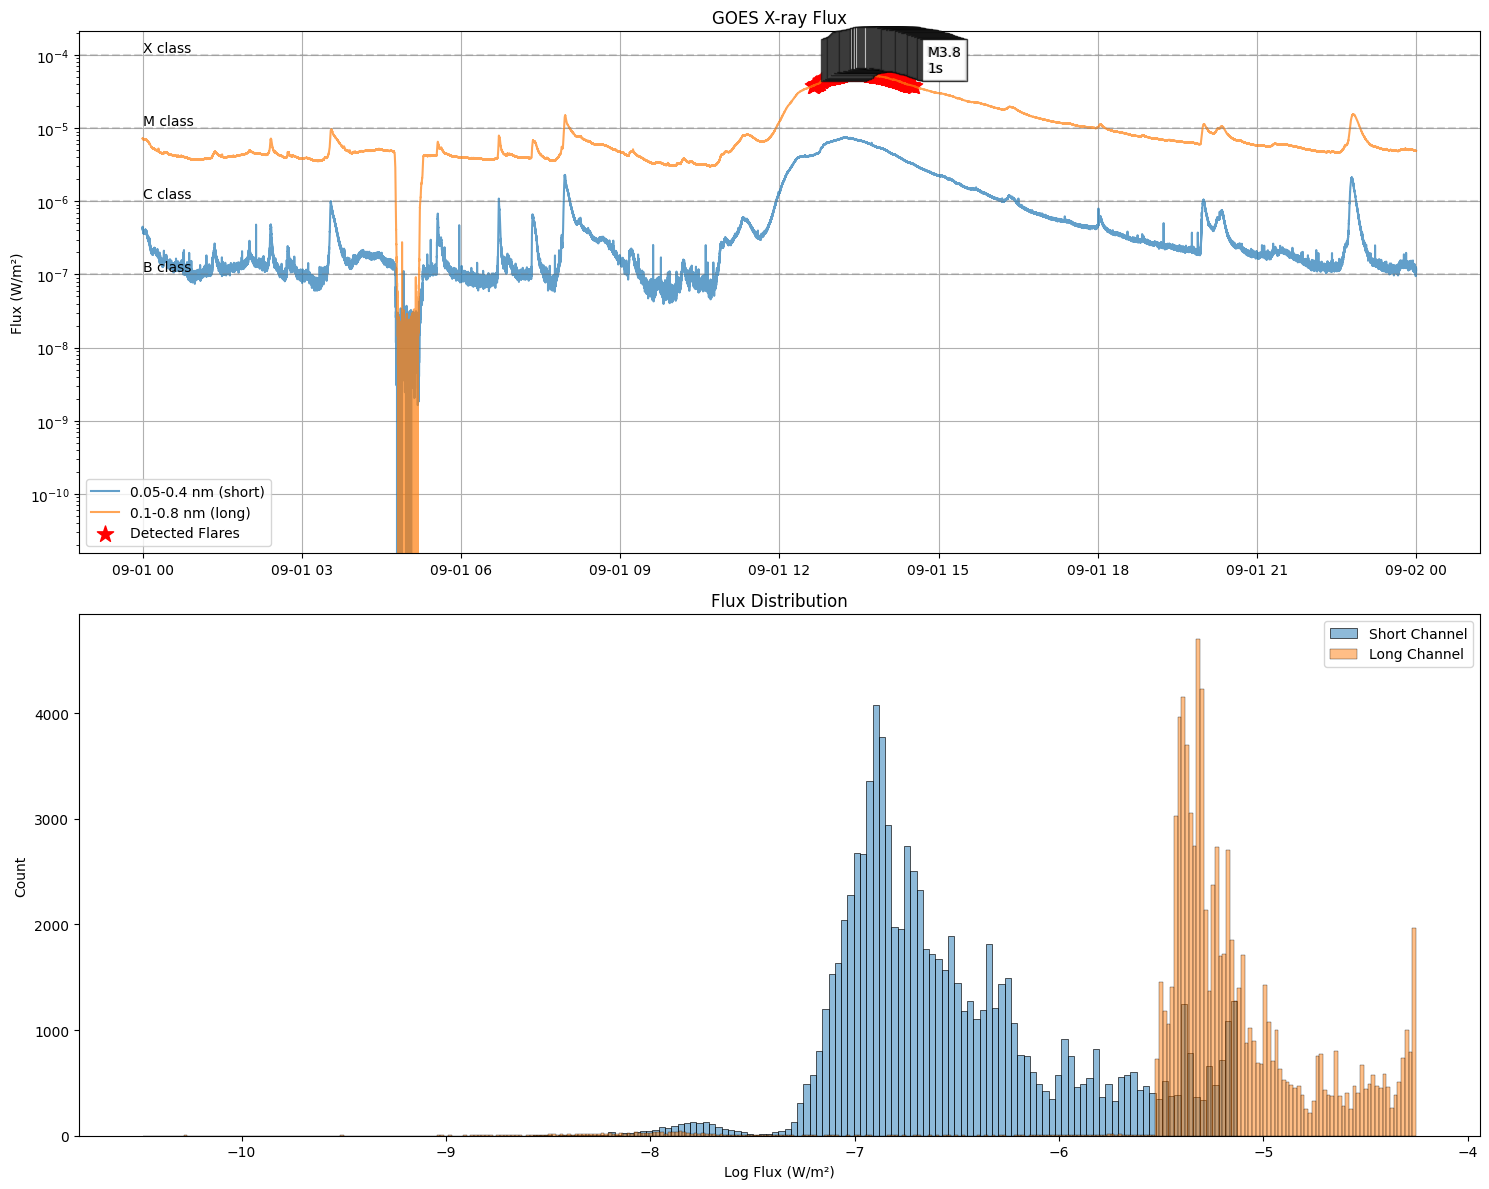

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
from datetime import datetime

class SolarFlareAnalyzer:
    def __init__(self):
        self.flare_classes = {
            'B': 1e-7,
            'C': 1e-6,
            'M': 1e-5,
            'X': 1e-4
        }

    def analyze_goes_data(self, goes_data_list):
        """
        Analyze GOES X-ray flux data from SunPy TimeSeries
        Args:
            goes_data_list: List of SunPy TimeSeries objects
        Returns:
            dict: Analysis results
        """
        # Get the first TimeSeries object
        goes_ts = goes_data_list[0]

        # Convert TimeSeries data to DataFrame
        df = goes_ts.to_dataframe()

        # GOES channels:
        # xrsa: 0.05-0.4 nm (short channel)
        # xrsb: 0.1-0.8 nm (long channel)

        times = df.index
        short_flux = df['xrsa'].astype(float)  # Short channel
        long_flux = df['xrsb'].astype(float)   # Long channel

        # Calculate statistics for both channels
        stats = {
            'short_mean_flux': np.mean(short_flux),
            'short_max_flux': np.max(short_flux),
            'short_min_flux': np.min(short_flux),
            'short_std_flux': np.std(short_flux),
            'long_mean_flux': np.mean(long_flux),
            'long_max_flux': np.max(long_flux),
            'long_min_flux': np.min(long_flux),
            'long_std_flux': np.std(long_flux)
        }

        # Detect flares using long channel (more sensitive to flares)
        peaks, _ = signal.find_peaks(long_flux,
                                   height=np.mean(long_flux) + 2*np.std(long_flux),
                                   distance=60)  # At least 1 minute between peaks

        # Classify flares
        flares = []
        for peak in peaks:
            peak_flux = long_flux.iloc[peak]
            flare_class = self._classify_flare(peak_flux)

            # Find start of flare (when flux starts rising)
            start_idx = peak
            while start_idx > 0 and long_flux.iloc[start_idx-1] <= long_flux.iloc[start_idx]:
                start_idx -= 1

            # Find end of flare (when flux returns to near-background)
            end_idx = peak
            background_level = long_flux.iloc[start_idx]
            while end_idx < len(long_flux)-1 and long_flux.iloc[end_idx] > background_level * 1.1:
                end_idx += 1

            flares.append({
                'start_time': times[start_idx],
                'peak_time': times[peak],
                'end_time': times[end_idx],
                'peak_flux': peak_flux,
                'class': flare_class,
                'duration': (times[end_idx] - times[start_idx]).total_seconds()
            })

        return {
            'statistics': stats,
            'flares': flares,
            'times': times,
            'short_flux': short_flux,
            'long_flux': long_flux,
            'dataframe': df
        }

    def plot_goes_analysis(self, analysis_results):
        """Plot the analysis results"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Plot both channels
        ax1.semilogy(analysis_results['times'],
                    analysis_results['short_flux'],
                    label='0.05-0.4 nm (short)',
                    alpha=0.7)
        ax1.semilogy(analysis_results['times'],
                    analysis_results['long_flux'],
                    label='0.1-0.8 nm (long)',
                    alpha=0.7)

        # Add flare class threshold lines
        for class_letter, threshold in self.flare_classes.items():
            ax1.axhline(y=threshold, color='gray', linestyle='--', alpha=0.3)
            ax1.text(analysis_results['times'][0], threshold,
                    f'{class_letter} class', va='bottom')

        # Plot detected flares
        if analysis_results['flares']:
            peak_times = [f['peak_time'] for f in analysis_results['flares']]
            peak_fluxes = [f['peak_flux'] for f in analysis_results['flares']]
            ax1.scatter(peak_times, peak_fluxes, color='red', marker='*',
                       s=150, label='Detected Flares')

            # Add flare class annotations
            for flare in analysis_results['flares']:
                ax1.annotate(f"{flare['class']}\n{flare['duration']:.0f}s",
                           (flare['peak_time'], flare['peak_flux']),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(facecolor='white', alpha=0.7))

        ax1.set_ylabel('Flux (W/m²)')
        ax1.set_title('GOES X-ray Flux')
        ax1.grid(True)
        ax1.legend()

        # Plot flux distribution for both channels
        sns.histplot(data=np.log10(analysis_results['short_flux']),
                    label='Short Channel', alpha=0.5, ax=ax2)
        sns.histplot(data=np.log10(analysis_results['long_flux']),
                    label='Long Channel', alpha=0.5, ax=ax2)
        ax2.set_xlabel('Log Flux (W/m²)')
        ax2.set_title('Flux Distribution')
        ax2.legend()

        plt.tight_layout()
        return fig

    def _classify_flare(self, flux):
        """Classify flare based on peak flux"""
        for class_letter in ['B', 'C', 'M', 'X']:
            class_flux = self.flare_classes[class_letter]
            if flux < class_flux * 10:
                magnitude = flux / class_flux
                return f"{class_letter}{magnitude:.1f}"
        return f"X{flux / self.flare_classes['X']:.1f}"

    def get_summary(self, analysis_results):
        """Get a summary of the analysis"""
        summary = {
            'total_flares': len(analysis_results['flares']),
            'flux_statistics': analysis_results['statistics']
        }

        # Count flares by class
        class_counts = {}
        for flare in analysis_results['flares']:
            class_letter = flare['class'][0]  # Get main class letter (B, C, M, or X)
            class_counts[class_letter] = class_counts.get(class_letter, 0) + 1

        summary['flare_classes'] = class_counts

        return summary

# Initialize the analyzer
analyzer = SolarFlareAnalyzer()

# Analyze GOES data
if goes_data is not None:
    goes_analysis = analyzer.analyze_goes_data(goes_data)
    goes_plot = analyzer.plot_goes_analysis(goes_analysis)

    # Get and print summary
    summary = analyzer.get_summary(goes_analysis)

    print("\nAnalysis Summary:")
    print(f"Total flares detected: {summary['total_flares']}")

    print("\nFlares by class:")
    for class_letter, count in summary['flare_classes'].items():
        print(f"{class_letter}-class: {count}")

    print("\nFlux Statistics:")
    for key, value in summary['flux_statistics'].items():
        print(f"{key}: {value:.2e}")

    # Save the plot
    goes_plot.savefig('goes_analysis.png')

/tmp/ipython-input-573746381.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  background_short = df['xrsa'].rolling(window_size).min()
/tmp/ipython-input-573746381.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  background_long = df['xrsb'].rolling(window_size).min()
/tmp/ipython-input-573746381.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'total_energy': np.trapz(df['xrsb'].iloc[start_idx:end_idx]),
/tmp/ipython-input-573746381.py:98: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df['xrsb'].resample('1H').mean()
/tmp/ipython-input-573746381.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_std = df['xrsb'].resample('1H').std()
/tmp/ipython-input-


Comprehensive Analysis Summary:
Total flares detected: 107

Flares by class:
M-class: 107

Average flare duration: 1.8 seconds
Channel correlation: 0.972
Strongest flare: M5.6


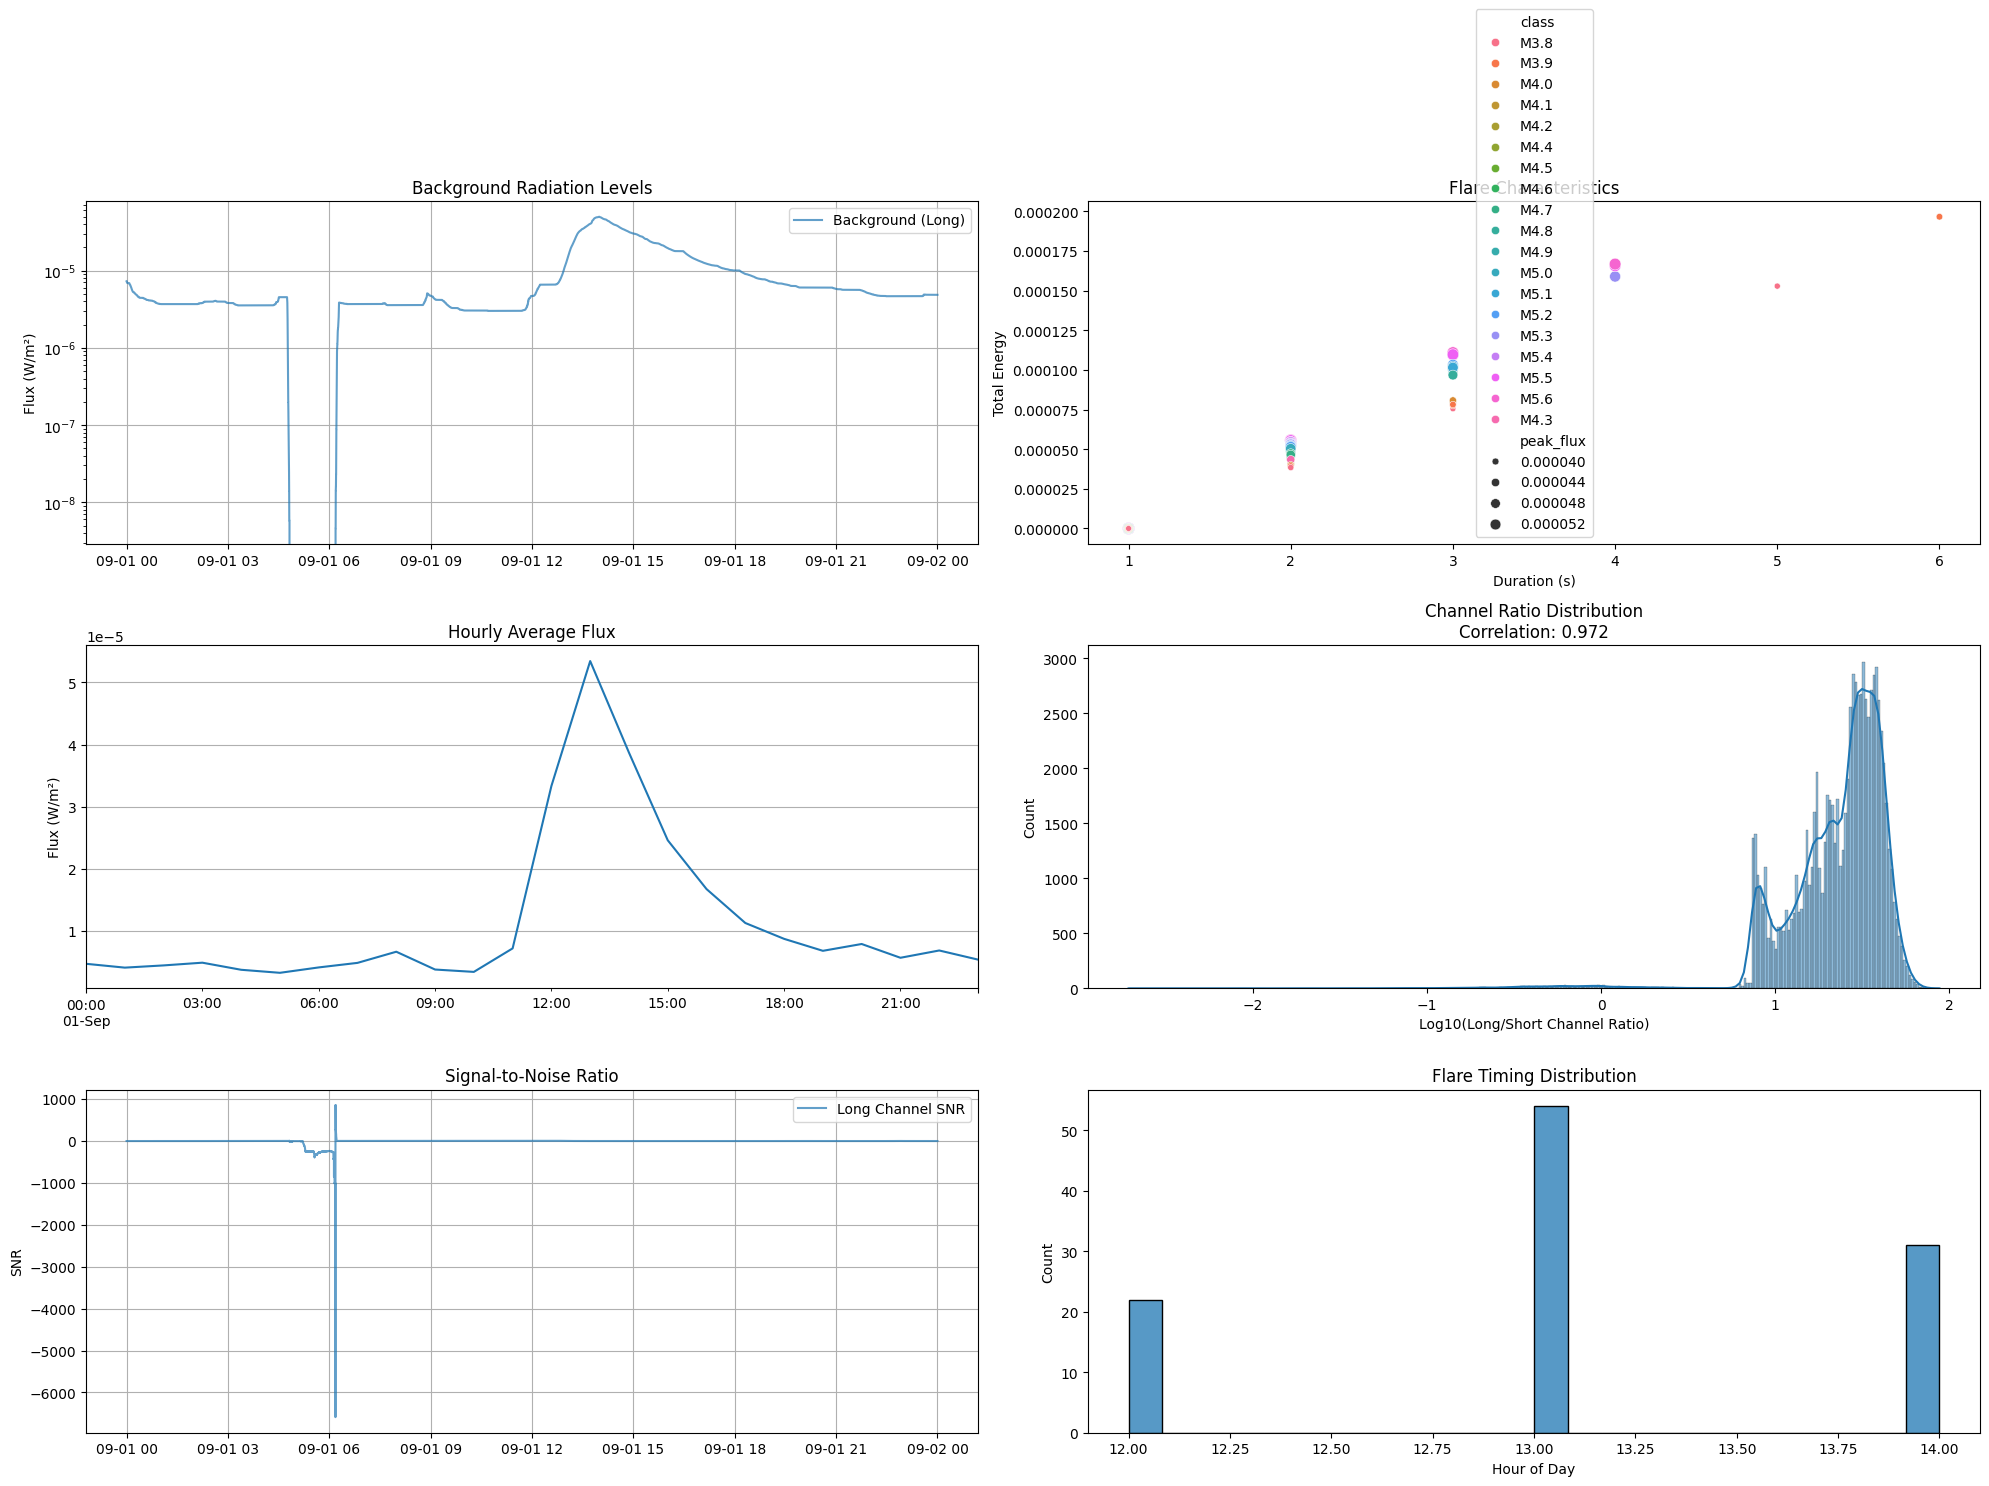

In [ ]:
# Extracts more interesting features from GOES X-ray data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, integrate
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class AdvancedSolarAnalyzer:
    def __init__(self):
        self.flare_classes = {
            'B': 1e-7,
            'C': 1e-6,
            'M': 1e-5,
            'X': 1e-4
        }

    def analyze_background_radiation(self, goes_data_list):
        """
        Analyze background X-ray radiation levels
        """
        goes_ts = goes_data_list[0]
        df = goes_ts.to_dataframe()

        # Calculate rolling minimum as background estimate
        window_size = '1H'  # 1-hour window
        background_short = df['xrsa'].rolling(window_size).min()
        background_long = df['xrsb'].rolling(window_size).min()

        # Calculate signal-to-noise ratio
        snr_short = df['xrsa'] / background_short
        snr_long = df['xrsb'] / background_long

        return {
            'background_short': background_short,
            'background_long': background_long,
            'snr_short': snr_short,
            'snr_long': snr_long,
            'times': df.index
        }

    def analyze_flare_characteristics(self, goes_data_list):
        """
        Detailed analysis of flare characteristics
        """
        goes_ts = goes_data_list[0]
        df = goes_ts.to_dataframe()

        # Find flares
        peaks, _ = signal.find_peaks(df['xrsb'],
                                   height=np.mean(df['xrsb']) + 2*np.std(df['xrsb']),
                                   distance=60)

        flare_characteristics = []
        for peak in peaks:
            # Find start and end of flare
            start_idx = peak
            while start_idx > 0 and df['xrsb'].iloc[start_idx-1] <= df['xrsb'].iloc[start_idx]:
                start_idx -= 1

            end_idx = peak
            background_level = df['xrsb'].iloc[start_idx]
            while end_idx < len(df['xrsb'])-1 and df['xrsb'].iloc[end_idx] > background_level * 1.1:
                end_idx += 1

            # Calculate characteristics
            flare_data = {
                'start_time': df.index[start_idx],
                'peak_time': df.index[peak],
                'end_time': df.index[end_idx],
                'peak_flux': df['xrsb'].iloc[peak],
                'class': self._classify_flare(df['xrsb'].iloc[peak]),
                'duration': (df.index[end_idx] - df.index[start_idx]).total_seconds(),
                'rise_time': (df.index[peak] - df.index[start_idx]).total_seconds(),
                'decay_time': (df.index[end_idx] - df.index[peak]).total_seconds(),
                'total_energy': np.trapz(df['xrsb'].iloc[start_idx:end_idx]),
                'peak_to_background': df['xrsb'].iloc[peak] / df['xrsb'].iloc[start_idx],
                'rise_rate': (df['xrsb'].iloc[peak] - df['xrsb'].iloc[start_idx]) /
                            (peak - start_idx) if peak > start_idx else 0,
                'decay_rate': (df['xrsb'].iloc[end_idx] - df['xrsb'].iloc[peak]) /
                             (end_idx - peak) if end_idx > peak else 0
            }
            flare_characteristics.append(flare_data)

        return pd.DataFrame(flare_characteristics)

    def analyze_temporal_patterns(self, goes_data_list):
        """
        Analyze temporal patterns in solar activity
        """
        goes_ts = goes_data_list[0]
        df = goes_ts.to_dataframe()

        # Resample data to different time scales
        hourly = df['xrsb'].resample('1H').mean()
        daily = df['xrsb'].resample('1D').mean()

        # Calculate variability metrics
        hourly_std = df['xrsb'].resample('1H').std()
        hourly_range = df['xrsb'].resample('1H').max() - df['xrsb'].resample('1H').min()

        return {
            'hourly_means': hourly,
            'daily_means': daily,
            'hourly_std': hourly_std,
            'hourly_range': hourly_range
        }

    def analyze_dual_channel_correlation(self, goes_data_list):
        """
        Analyze correlation between short and long wavelength channels
        """
        goes_ts = goes_data_list[0]
        df = goes_ts.to_dataframe()

        # Calculate correlation
        correlation = df['xrsa'].corr(df['xrsb'])

        # Calculate ratio between channels
        channel_ratio = df['xrsb'] / df['xrsa']

        return {
            'correlation': correlation,
            'channel_ratio': channel_ratio,
            'times': df.index
        }

    def plot_advanced_analysis(self, background_results, flare_chars, temporal_results, correlation_results):
        """
        Create comprehensive visualizations of the advanced analysis
        """
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2)

        # Background radiation plot
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.semilogy(background_results['times'], background_results['background_long'],
                    label='Background (Long)', alpha=0.7)
        ax1.set_title('Background Radiation Levels')
        ax1.set_ylabel('Flux (W/m²)')
        ax1.grid(True)
        ax1.legend()

        # Flare characteristics
        ax2 = fig.add_subplot(gs[0, 1])
        if len(flare_chars) > 0:
            sns.scatterplot(data=flare_chars, x='duration', y='total_energy',
                          hue='class', size='peak_flux', ax=ax2)
            ax2.set_title('Flare Characteristics')
            ax2.set_xlabel('Duration (s)')
            ax2.set_ylabel('Total Energy')

        # Temporal patterns
        ax3 = fig.add_subplot(gs[1, 0])
        temporal_results['hourly_means'].plot(ax=ax3)
        ax3.set_title('Hourly Average Flux')
        ax3.set_ylabel('Flux (W/m²)')
        ax3.grid(True)

        # Channel correlation
        ax4 = fig.add_subplot(gs[1, 1])
        sns.histplot(data=np.log10(correlation_results['channel_ratio']),
                    kde=True, ax=ax4)
        ax4.set_title(f'Channel Ratio Distribution\nCorrelation: {correlation_results["correlation"]:.3f}')
        ax4.set_xlabel('Log10(Long/Short Channel Ratio)')

        # Signal-to-Noise Ratio
        ax5 = fig.add_subplot(gs[2, 0])
        ax5.plot(background_results['times'], background_results['snr_long'],
                label='Long Channel SNR', alpha=0.7)
        ax5.set_title('Signal-to-Noise Ratio')
        ax5.set_ylabel('SNR')
        ax5.grid(True)
        ax5.legend()

        # Flare timing distribution
        ax6 = fig.add_subplot(gs[2, 1])
        if len(flare_chars) > 0:
            flare_hours = pd.to_datetime(flare_chars['peak_time']).dt.hour
            sns.histplot(data=flare_hours, bins=24, ax=ax6)
            ax6.set_title('Flare Timing Distribution')
            ax6.set_xlabel('Hour of Day')

        plt.tight_layout()
        return fig

    def _classify_flare(self, flux):
        """Helper function to classify flares"""
        for class_letter in ['B', 'C', 'M', 'X']:
            class_flux = self.flare_classes[class_letter]
            if flux < class_flux * 10:
                magnitude = flux / class_flux
                return f"{class_letter}{magnitude:.1f}"
        return f"X{flux / self.flare_classes['X']:.1f}"

    def get_comprehensive_summary(self, flare_chars, correlation_results):
        """Generate a comprehensive summary of the analysis"""
        summary = {
            'total_flares': len(flare_chars),
            'flare_classes': flare_chars['class'].str[0].value_counts().to_dict(),
            'avg_duration': flare_chars['duration'].mean(),
            'avg_energy': flare_chars['total_energy'].mean(),
            'channel_correlation': correlation_results['correlation'],
            'strongest_flare': flare_chars.loc[flare_chars['peak_flux'].idxmax(), 'class']
            if len(flare_chars) > 0 else None
        }
        return summary

# Initialize the advanced analyzer
advanced_analyzer = AdvancedSolarAnalyzer()

if goes_data is not None:
    # Perform various analyses
    background = advanced_analyzer.analyze_background_radiation(goes_data)
    flare_characteristics = advanced_analyzer.analyze_flare_characteristics(goes_data)
    temporal_patterns = advanced_analyzer.analyze_temporal_patterns(goes_data)
    channel_correlation = advanced_analyzer.analyze_dual_channel_correlation(goes_data)

    # Create visualization
    advanced_plot = advanced_analyzer.plot_advanced_analysis(
        background, flare_characteristics, temporal_patterns, channel_correlation
    )

    # Get comprehensive summary
    summary = advanced_analyzer.get_comprehensive_summary(
        flare_characteristics, channel_correlation
    )

    print("\nComprehensive Analysis Summary:")
    print(f"Total flares detected: {summary['total_flares']}")
    print("\nFlares by class:")
    for class_letter, count in summary['flare_classes'].items():
        print(f"{class_letter}-class: {count}")
    print(f"\nAverage flare duration: {summary['avg_duration']:.1f} seconds")
    print(f"Channel correlation: {summary['channel_correlation']:.3f}")
    print(f"Strongest flare: {summary['strongest_flare']}")

    # Save the plot
    advanced_plot.savefig('advanced_solar_analysis.png')